# Prepare dataset

## Gdrive setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision torchsummary

In [9]:

import os

project_root = '/content/drive/MyDrive/game_AI_project'
# project_root = '/home/hp2427/mvst'
data_root = project_root + '/data'
vid_root = data_root + '/videos'
mask_root = data_root + '/masks'
annotations_file_train = data_root + '/annotations_train.txt'
annotations_file_val = data_root + '/annotations_val.txt'
annotations_file_test = data_root + '/annotations_test.txt'
style_root = data_root + '/style'
style_class_dir = style_root + '/all'
checkpoints_root = project_root + '/checkpoints'
sample_output_root = project_root + '/sample_output'

cur_dir = '/content'
# cur_dir = '/home/hp2427/mvst'

for dir in [project_root, data_root, vid_root, mask_root, style_root, style_class_dir, checkpoints_root, sample_output_root]:
    try:
        os.mkdir(dir)
    except OSError as error:
        print(error)

[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data/videos'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data/masks'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data/style'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data/style/all'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/checkpoints'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/sample_output'


## get video_dataset.py

In [5]:
!rm -rf Video-Dataset-Loading-Pytorch*

In [6]:
!git clone https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch.git

Cloning into 'Video-Dataset-Loading-Pytorch'...
remote: Enumerating objects: 411, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 411 (delta 72), reused 54 (delta 54), pack-reused 328
Receiving objects: 100% (411/411), 6.70 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [7]:
!cp Video-Dataset-Loading-Pytorch/video_dataset.py ./video_dataset.py

In [8]:
!rm -rf Video-Dataset-Loading-Pytorch/

## Download and unzip DAVIS dataset [Not required if already present on mounted google drive]

In [ ]:
!git clone https://github.com/davisvideochallenge/davis-2017.git

In [ ]:
!davis-2017/data/get_davis.sh

In [ ]:
! rm -rf davis-2017/

### Copy data to Google drive, only if required

In [ ]:
#remove dirs where num frames do not match
import os
import os.path as path
# vid_path = '/content/DAVIS/JPEGImages/480p'
# mask_path = '/content/DAVIS/Annotations/480p'

vid_path = cur_dir + '/DAVIS/JPEGImages/480p'
mask_path = cur_dir + '/DAVIS/Annotations/480p'

annotations = []
for f in os.listdir(vid_path):
    if len(os.listdir(path.join(vid_path, f))) != len(os.listdir(path.join(mask_path, f))) or len(os.listdir(path.join(mask_path, f))) == 0:
        print('removing ', f)
        for g in os.listdir(path.join(vid_path, f)):
            os.remove(path.join(vid_path, f, g))
        for g in os.listdir(path.join(mask_path, f)):
            os.remove(path.join(mask_path, f, g))
        os.rmdir(path.join(vid_path, f))
        os.rmdir(path.join(mask_path, f))
    else:
        # print(f)
        min_frame = min(os.listdir(path.join(vid_path, f)))[:-4]
        max_frame = max(os.listdir(path.join(vid_path, f)))[:-4]
        annotations.append((f, min_frame, max_frame, 0))
print(annotations)

In [ ]:
train_count = 60
val_count = 15
test_count = 15

with open(cur_dir + '/annotations_train.txt', 'w') as f:
    for ann in annotations[:train_count]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

with open(cur_dir + '/annotations_val.txt', 'w') as f:
    for ann in annotations[train_count:train_count+val_count]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

with open(cur_dir + '/annotations_test.txt', 'w') as f:
    for ann in annotations[train_count+val_count:]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

In [ ]:
## !rm -rf /content/drive/MyDrive/game_AI_project/data/videos/*
## !rm -rf /content/drive/MyDrive/game_AI_project/data/masks/*
# !mv /content/annotations_train.txt /content/drive/MyDrive/game_AI_project/data/annotations_train.txt
# !mv /content/annotations_val.txt /content/drive/MyDrive/game_AI_project/data/annotations_val.txt
# !mv /content/annotations_test.txt /content/drive/MyDrive/game_AI_project/data/annotations_test.txt
# !mv /content/DAVIS/JPEGImages/480p/* /content/drive/MyDrive/game_AI_project/data/videos/
# !mv /content/DAVIS/Annotations/480p/* /content/drive/MyDrive/game_AI_project/data/masks/

!mv /home/hp2427/mvst/annotations_train.txt /home/hp2427/mvst/data/annotations_train.txt
!mv /home/hp2427/mvst/annotations_val.txt /home/hp2427/mvst/data/annotations_val.txt
!mv /home/hp2427/mvst/annotations_test.txt /home/hp2427/mvst/data/annotations_test.txt
!mv /home/hp2427/mvst/DAVIS/JPEGImages/480p/* /home/hp2427/mvst/data/videos/
!mv /home/hp2427/mvst/DAVIS/Annotations/480p/* /home/hp2427/mvst/data/masks/
!rm -rf /home/hp2427/mvst/DAVIS/

## Visualize video data samples

In [10]:
from video_dataset import  VideoFrameDataset, ImglistToTensor
from torchvision import transforms
import torch
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os


def plot_video(rows, cols, frame_list, plot_width, plot_height, title: str):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.suptitle(title)
    plt.show()


def denormalize(video_tensor):
        """
        Undoes mean/standard deviation normalization, zero to one scaling,
        and channel rearrangement for a batch of images.
        args:
            video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        """
        inverse_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        )
        return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


def video_dataset_demo():
    """
    This demo uses the dummy dataset inside of the folder "demo_dataset".
    It is structured just like a real dataset would need to be structured.

    TABLE OF CODE CONTENTS:
    1. Minimal demo without image transforms
    2. Minimal demo without sparse temporal sampling for single continuous frame clips, without image transforms
    3. Demo with image transforms
    4. Demo 3 continued with PyTorch dataloader
    5. Demo of using a dataset where samples have multiple separate class labels

    """
    # videos_root = os.path.join('/content', 'DAVIS/JPEGImages/480p')
    # masks_root = os.path.join('/content', 'DAVIS/Annotations/480p')
    # annotation_file = os.path.join('/content', 'annotations.txt')
    videos_root = vid_root
    masks_root = mask_root
    annotation_file = annotations_file_train

    preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    preprocess_mask = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    """ DEMO 1 WITHOUT IMAGE TRANSFORMS """
    dataset = VideoFrameDataset(
        root_path=videos_root,
        annotationfile_path=annotation_file,
        num_segments=10,
        frames_per_segment=1,
        imagefile_template='{:05d}.jpg',
        transform=preprocess,
        test_mode=True
    )

    sample = dataset[10]
    frames = sample[0]  # list of PIL images
    label = sample[1]   # integer label

    plot_video(rows=1, cols=5, frame_list=denormalize(frames), plot_width=15., plot_height=3.,
               title='Evenly Sampled Frames')

    mask_dataset = VideoFrameDataset(
        root_path=masks_root,
        annotationfile_path=annotation_file,
        num_segments=10,
        frames_per_segment=1,
        imagefile_template='{:05d}.png',
        transform=preprocess_mask,
        test_mode=True
    )

    mask_sample = mask_dataset[10]
    mask_frames = mask_sample[0]  # list of PIL images
    mask_label = mask_sample[1]   # integer label

    plot_video(rows=1, cols=5, frame_list=(mask_frames * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Frames')
    print('Dataset size : ', len(dataset))


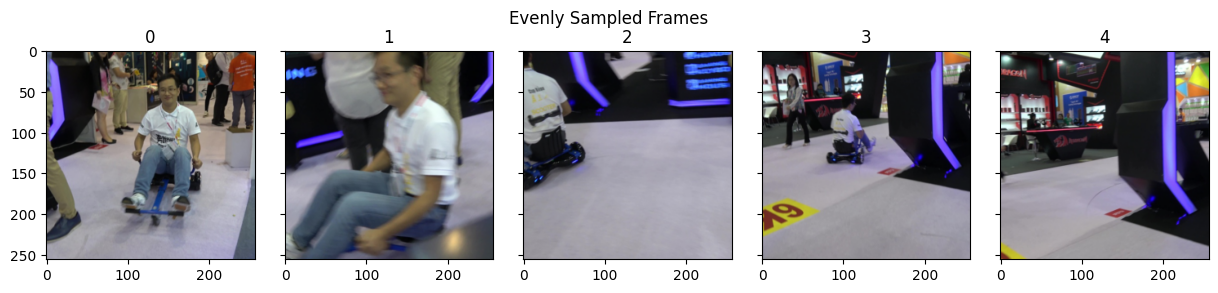

<ipython-input-10-589c496fbfb8>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


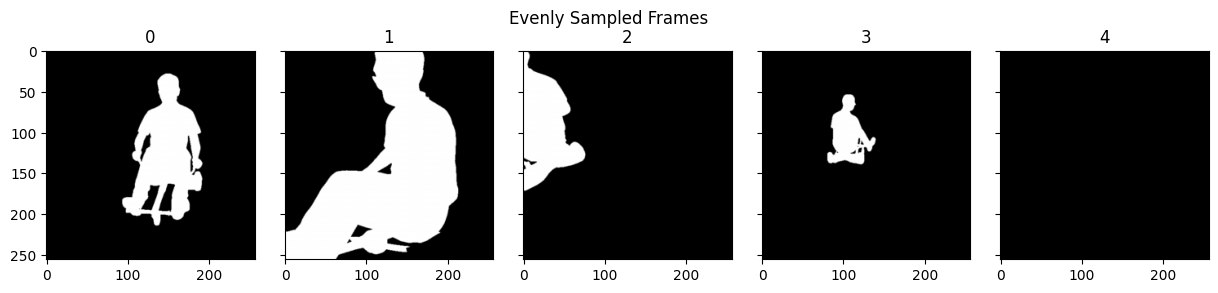

Dataset size :  60


In [11]:
video_dataset_demo()

## Download and unzip style dataset [Not required if already present on mounted google drive]

In [ ]:
!git clone https://github.com/himanshu1196/game-ai-style-transfer.git

In [ ]:
# !mv game-ai-style-transfer/data/style_random100.zip /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip
# !unzip /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip -d /content/drive/MyDrive/game_AI_project/data/style/all/
# !rm /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip
# !mv /content/drive/MyDrive/game_AI_project/data/style/all/style_random100/* /content/drive/MyDrive/game_AI_project/data/style/all/
# !rm -rf /content/drive/MyDrive/game_AI_project/data/style/all/style_random100/

!mv game-ai-style-transfer/data/style_random100.zip /home/hp2427/mvst/data/style/all/random100.zip
!unzip /home/hp2427/mvst/data/style/all/random100.zip -d /home/hp2427/mvst/data/style/all/
!rm /home/hp2427/mvst/data/style/all/random100.zip
!mv /home/hp2427/mvst/data/style/all/style_random100/* /home/hp2427/mvst/data/style/all/
!rm -rf /home/hp2427/mvst/data/style/all/style_random100/

## Visualize style dataset

In [12]:
!rm -rf /content/drive/MyDrive/game_AI_project/data/style/.ipynb_checkpoints/
!ls -a /content/drive/MyDrive/game_AI_project/data/style/

all


In [13]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

style_dataset = torchvision.datasets.ImageFolder(style_root, transforms.Compose([
    transforms.Resize(256),  # image batch, resize smaller edge to 299
    transforms.CenterCrop(256),  # image batch, center crop to square 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

rnd_idx = np.random.randint(100)
plt.imshow(denormalize(style_dataset[rnd_idx][0].unsqueeze(0))[0])

## Define MVST Dataset

In [14]:
import os
from PIL import Image
import torch.nn.functional as F

import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_video
from torch.utils.data import Dataset
import random
from video_dataset import  VideoFrameDataset, ImglistToTensor

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image

def denormalize(video_tensor):
    """
    Undoes mean/standard deviation normalization, zero to one scaling,
    and channel rearrangement for a batch of images.
    args:
        video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    """
    inverse_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


class MVSTDataset(Dataset):
    def __init__(self,cont_vids_path, cont_mask_vids_path, annotations_path, style_imgs_path, num_classes, img_size=256):

        self.preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.preprocess_mask = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.cont_vids_path = cont_vids_path
        self.cont_mask_vids_path = cont_mask_vids_path
        self.annotation_file = annotations_path
        self.style_imgs_path = style_imgs_path
        self.style_img_files = self.list_files(style_imgs_path)
        self.img_size = img_size
        assert(num_classes == 2)
        self.num_classes = num_classes
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size,self.img_size), Image.BICUBIC),
            transforms.ToTensor()
        ])
        self.FRAME_COUNT = 100
        self.dataset = VideoFrameDataset(
            root_path=cont_vids_path,
            annotationfile_path=annotations_path,
            num_segments=10,
            frames_per_segment=1,
            imagefile_template='{:05d}.jpg',
            transform=self.preprocess,
            test_mode=True
        )

        self.mask_dataset = VideoFrameDataset(
            root_path=cont_mask_vids_path,
            annotationfile_path=annotations_path,
            num_segments=10,
            frames_per_segment=1,
            imagefile_template='{:05d}.png',
            transform=self.preprocess_mask,
            test_mode=True
        )

        self.style_dataset = torchvision.datasets.ImageFolder(self.style_imgs_path, transforms.Compose([
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,idx):
        # two random style images
        style_idx1 = np.random.randint(len(self.style_dataset))
        style_idx2 = np.random.randint(len(self.style_dataset))
        while style_idx2 == style_idx1:
            style_idx2 = np.random.randint(len(self.style_dataset))

        cont_idx = idx

        cont_vid_item = self.dataset.__getitem__(cont_idx)[0]
        cont_mask_vid_item = self.mask_dataset.__getitem__(cont_idx)[0]
        style_img_item1 = self.style_dataset.__getitem__(style_idx1)[0]
        style_img_item2 = self.style_dataset.__getitem__(style_idx2)[0]

        cont_mask_vid_item = torch.unsqueeze(cont_mask_vid_item, 0) # 1xFx3x256x256

        style_img_item1 = torch.unsqueeze(style_img_item1, 0) # 1x3x256x256
        style_img_item2 = torch.unsqueeze(style_img_item2, 0) # 1x3x256x256
        # print(f'loading : {cont_mask_vid_item.min()} {cont_mask_vid_item.max()} {(1-cont_mask_vid_item).min()} {(1-cont_mask_vid_item).max()}')
        return cont_vid_item, torch.cat([cont_mask_vid_item, 1-cont_mask_vid_item], dim=0), torch.cat([style_img_item1, style_img_item2], dim=0)


    def list_files(self, in_path):
        files = []
        for (dirpath, dirnames, filenames) in os.walk(in_path):
            files.extend(filenames)
            break
        files = sorted([os.path.join(in_path, x) for x in files])
        return files


### Visualize MVSTDataset

Using device: cpu


<ipython-input-14-96658158698e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


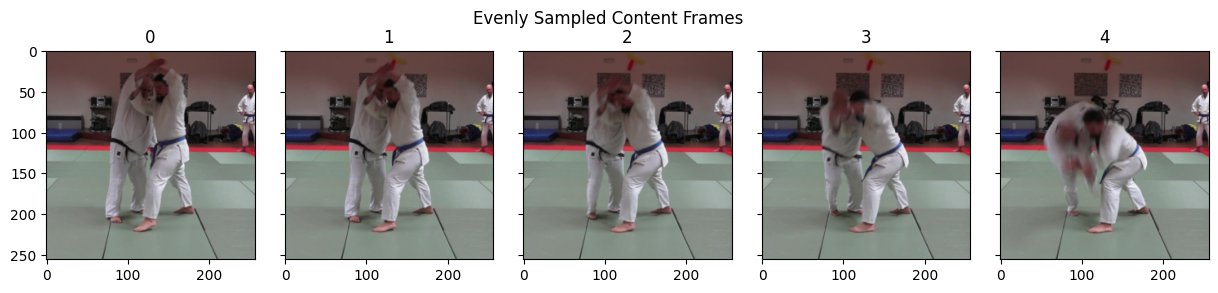

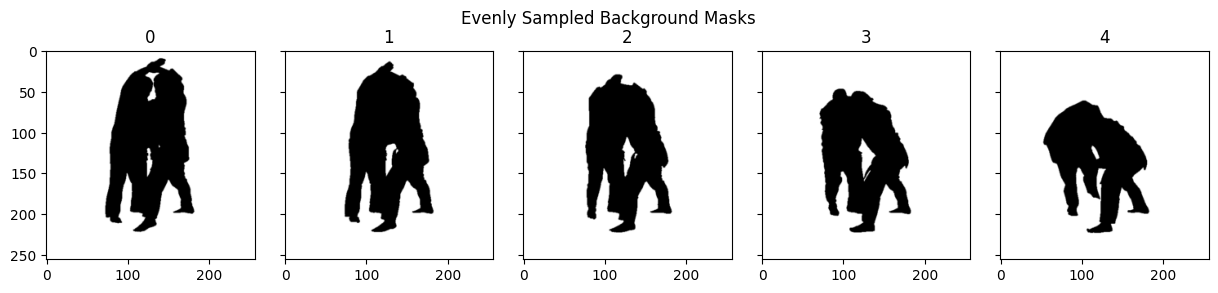

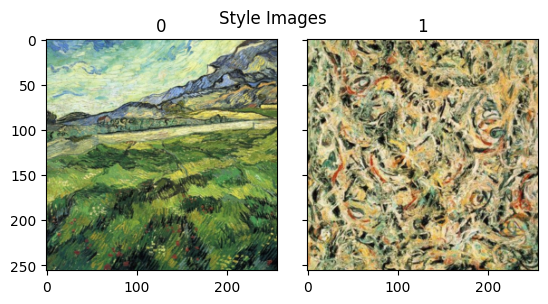

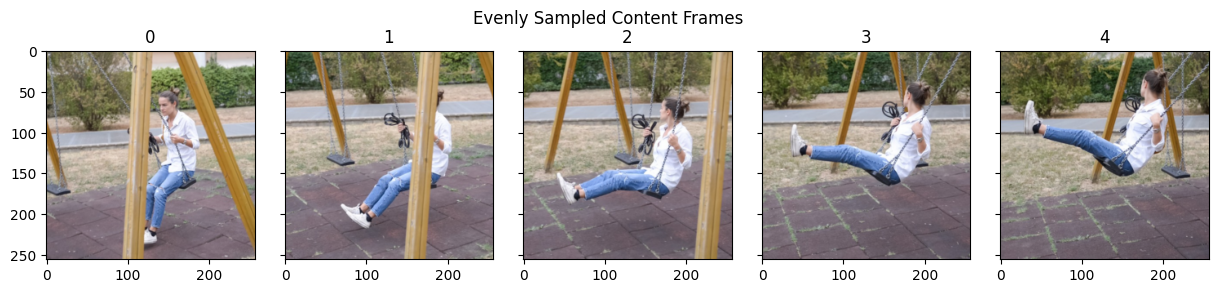

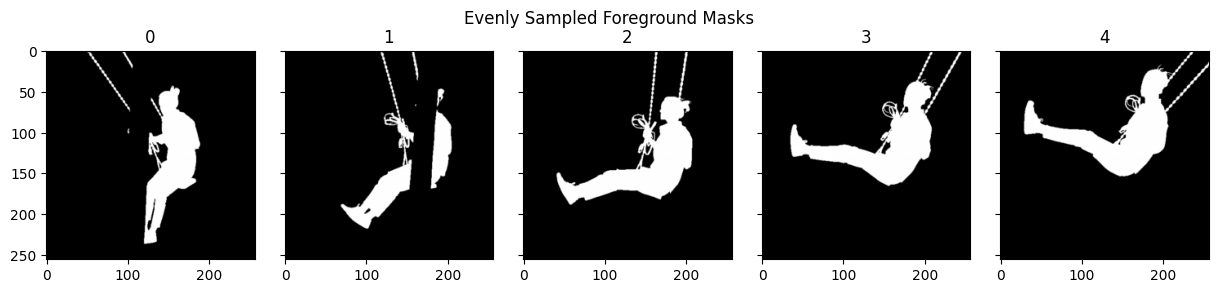

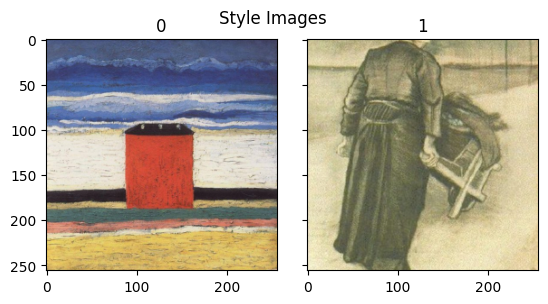

In [15]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import Raft_Small_Weights
import sys

args = {}
args['cont_vids_path'] = vid_root #/vids
args['cont_mask_vids_path'] = mask_root #/mask_vids
args['annotations_path'] = annotations_file_val #/mask_vids
args['style_imgs_path'] = style_root #/style_images
args['num_classes'] = 2
args['batch_size'] = 1
args['checkpoint_path'] = checkpoints_root
args['output_path'] = sample_output_root
args['log_interval'] = 1
args['ckpt_interval'] = 2

cont_vids_path = args['cont_vids_path'] #/vids
cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
annotations_path = args['annotations_path'] #/annotations_path
style_imgs_path = args['style_imgs_path'] #/style_images
num_classes = args['num_classes'] #/num_classes
batch_size = args['batch_size']
checkpoint_path = args['checkpoint_path']
output_path = args['output_path']
log_interval = args['log_interval']
ckpt_interval = args['ckpt_interval']

# set dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
val_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path, style_imgs_path, num_classes, img_size=256)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

count = 0
for i ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(val_loader):
    #cont_img is B x num_frames x 3 x 256 x 256
    plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
               title='Evenly Sampled Content Frames')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Foreground Masks')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Background Masks')
    plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
               title='Style Images')
    count += 1
    if count >1:
        break

# Masked Video Style Transfer Model

### Define model

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision import models
from torchsummary import summary
from torchvision.models.feature_extraction import create_feature_extractor

In [32]:
# model architecture

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def ada_in(style_features, content_cur_masked_features):
    # print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape) #BxCxSxS

    x_cur_mean, x_cur_std = calc_mean_std(content_cur_masked_features)

    style_mean, style_std = calc_mean_std(style_features)

    result = style_std * (content_cur_masked_features - x_cur_mean) / x_cur_std + style_mean
    return result

def st_ada_in(style_features, content_cur_masked_features, content_prev_masked_features, alpha = 0.1):
    # print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape) #BxCxSxS

    x_cur_mean, x_cur_std = calc_mean_std(content_cur_masked_features)
    x_prev_mean, x_prev_std = calc_mean_std(content_prev_masked_features)

    # print('#', type(alpha), type(x_cur_mean), type(x_prev_mean))
    combined_mean = (1-alpha) * x_cur_mean + alpha * x_prev_mean
    combined_std = (1-alpha) * x_cur_std + alpha * x_prev_std

    style_mean, style_std = calc_mean_std(style_features)

    result = style_std * (content_cur_masked_features - combined_mean) / combined_std + style_mean
    # print('#', x_cur_mean.shape, style_mean.shape, result.shape)
    # print('STAdaIn :', x_cur_mean.squeeze()[:5], x_cur_std.squeeze()[:5], x_prev_mean.squeeze()[:5], x_prev_std.squeeze()[:5], style_mean.squeeze()[:5], style_std.squeeze()[:5], calc_mean_std(result)[0].squeeze()[:5], calc_mean_std(result)[1].squeeze()[:5])
    return result


def get_VGG_feature_extractor():
    # vgg_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    # vgg_layer_names = ["ReLU-2", "ReLU-7", "ReLU-12", "ReLU-21"]
    vgg_fixed = torchvision.models.vgg19(weights='IMAGENET1K_V1')
    for param in vgg_fixed.parameters():
        param.requires_grad = False

    # train_nodes, eval_nodes = get_graph_node_names(vgg_fixed)
    # print(train_nodes, eval_nodes)

    # To specify the nodes you want to extract, you could select the final node
    # that appears in each of the main layers:
    return_nodes = {
        # node_name: user-specified key for output dict
        'features.2': 'layer1',
        'features.7': 'layer2',
        'features.12': 'layer3',
        'features.21': 'layer4',
    }

    return create_feature_extractor(vgg_fixed, return_nodes=return_nodes)


class SpatioTemporalTransferModel(nn.Module):
    def __init__(self, vgg_feature_extractor):
        super(SpatioTemporalTransferModel, self).__init__()
        self.vgg_feature_extractor = vgg_feature_extractor

        #define splatting blocks' layers
        self.sb_11 = ConvBlock(in_channels=64, out_channels=8, kernel_size=3,  padding="same", stride=2)
        self.sb_12 = ConvBlock(in_channels=8, out_channels=8, kernel_size=3,  padding="same", stride=1)
        self.sb_13 = ConvBlock(in_channels=8, out_channels=8, kernel_size=3,  padding="same", stride=1)
        self.sb_1_short = nn.Conv2d(in_channels=128, out_channels=8, kernel_size=1, stride=1)

        self.sb_21 = ConvBlock(in_channels=8, out_channels=16, kernel_size=3,  padding="same", stride=2)
        self.sb_22 = ConvBlock(in_channels=16, out_channels=16, kernel_size=3,  padding="same", stride=1)
        self.sb_23 = ConvBlock(in_channels=16, out_channels=16, kernel_size=3,  padding="same", stride=1)
        self.sb_2_short = nn.Conv2d(in_channels=256, out_channels=16, kernel_size=1,  stride=1)

        self.sb_31 = ConvBlock(in_channels=16, out_channels=32, kernel_size=3,  padding="same", stride=2)
        self.sb_32 = ConvBlock(in_channels=32, out_channels=32, kernel_size=3,  padding="same", stride=1)
        self.sb_33 = ConvBlock(in_channels=32, out_channels=32, kernel_size=3,  padding="same", stride=1)
        self.sb_3_short = nn.Conv2d(in_channels=512, out_channels=32, kernel_size=1, stride=1)

        self.l_1 = ConvBlock(in_channels=32, out_channels=64, kernel_size=3,  padding="same", stride=1)
        self.l_2 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3,  padding="same", stride=1)

        self.gp_1 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3,  padding="same", stride=1)

        self.gp_2 = ConvBlock(in_channels=256, out_channels=512, kernel_size=1,  padding="same", stride=1, activation=None) #TODO : activation none?
        return

    def forward(self, style, content, mask, mask_prev, cpe_1, cpe_2, cpe_3, cpe_4, adap_1, adap_2, adap_3):
        # Encode the style and content image.

        style_encoded_dict = self.vgg_feature_extractor(style)
        style_encoded = [style_encoded_dict[f'layer{i}'] for i in range(1,5)]

        content_encoded_dict = self.vgg_feature_extractor(content * mask)
        content_encoded = [content_encoded_dict[f'layer{i}'] for i in range(1,5)]

        # Compute the AdaIN target feature maps.
        st_ada_in_outputs = []
        # skip block1_conv1
        skipCount = 1
        count = 0
        content_prev_encoded = [cpe_1, cpe_2, cpe_3, cpe_4]
        for encoded_features in zip(style_encoded, content_encoded, content_prev_encoded):
            # print('! ', count)
            if count < skipCount:
                count += 1
                continue
            # TODO : consider mask shape
            st_ada_in_output = st_ada_in(encoded_features[0], encoded_features[1], encoded_features[2], alpha = 0.1)
            st_ada_in_outputs.append(st_ada_in_output)

        temp_content = self.sb_11(content_encoded[0]) #input is c_in
        temp_style = self.sb_11(style_encoded[0]) #input is s_in
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_1, alpha = 0.1)
        adap_1 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_1_short(st_ada_in_outputs[0])
        temp_content_stylized = self.sb_12(temp_content_stylized)
        temp_content_stylized = self.sb_13(temp_content_stylized) #c_out
        # print('here', temp_style.shape)
        temp_style = self.sb_13(temp_style) #s_out
        # print('STM sb1: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content = self.sb_21(temp_content_stylized) #input is c_in
        # print('STM sb21: ', temp_content.shape, temp_content.min(), temp_content.max())
        temp_style = self.sb_21(temp_style) #input is s_in
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_2, alpha = 0.1)
        # print('STM sb2ada: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        adap_2 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_2_short(st_ada_in_outputs[1])
        # print('STM sb2sum: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content_stylized = self.sb_22(temp_content_stylized)
        # print('STM sb22: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content_stylized = self.sb_23(temp_content_stylized) #c_out
        # print('STM sb23: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_style = self.sb_23(temp_style) #s_out
        # print('STM sb2: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content = self.sb_31(temp_content_stylized) #input is c_in
        temp_style = self.sb_31(temp_style) #input is s_in
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_3, alpha = 0.1)
        adap_3 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_3_short(st_ada_in_outputs[2])
        temp_content_stylized = self.sb_32(temp_content_stylized)
        temp_content_stylized = self.sb_33(temp_content_stylized) #c_out
        temp_style = self.sb_33(temp_style) #s_out
        # print('STM sb3: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content_stylized = self.l_1(temp_content_stylized)
        # print('STM l1: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content_stylized = self.l_2(temp_content_stylized) #stylized_features
        # print('STM l2: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        #grid prediction
        bilateral_grid = self.gp_1(temp_content_stylized)
        bilateral_grid = self.gp_2(bilateral_grid)

        content_prev_encoded = content_encoded.copy()
        # print('STM bg: ', bilateral_grid.shape, bilateral_grid.min(), bilateral_grid.max())
        # plt.matshow(torch.sum(temp_content_stylized.squeeze(), dim= (0)).cpu().detach().numpy())
        # plt.show()
        print('directly decoding ')
        plt.imshow(make_grid(infer_decoder(ada_in(content_encoded[-1], style_encoded[-1]))[0]).cpu().detach().permute(1,2,0).numpy())
        plt.show()
        return bilateral_grid, content_prev_encoded[0], content_prev_encoded[1], content_prev_encoded[2], content_prev_encoded[3], adap_1, adap_2, adap_3,

def get_decoder():
    return nn.Sequential(
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 256, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 128, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 128, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 64, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 3, (3, 3)),
    )

#########################################################################################################
class MaskedVideoStyleTransfer(nn.Module):
    def __init__(self, decoder):
        super(MaskedVideoStyleTransfer, self).__init__()
        self.vgg_feature_extractor = get_VGG_feature_extractor()
        self.spatio_temporal_model = SpatioTemporalTransferModel(self.vgg_feature_extractor)
        self.decoder = decoder


    def forward(self, content, mask_cur_list, style_list, mask_prev_list, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all):
        # model : torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 2, 64, 224, 224]) torch.Size([2, 2, 128, 112, 112]) torch.Size([2, 2, 256, 56, 56]) torch.Size([2, 2, 512, 28, 28]) torch.Size([2, 2, 8, 112, 112]) torch.Size([2, 2, 16, 56, 56]) torch.Size([2, 2, 32, 28, 28])
        # print('model :', content.shape, mask_cur_list.shape, style_list.shape, mask_prev_list.shape, cpe_1_all.shape, cpe_2_all.shape, cpe_3_all.shape, cpe_4_all.shape, adap_1_all.shape, adap_2_all.shape, adap_3_all.shape)

        bilateral_grid_list = []
        for classId in range(mask_cur_list.shape[1]):
            bilateral_grid, cpe_1_, cpe_2_, cpe_3_, cpe_4_, adap_1, adap_2, adap_3 = self.spatio_temporal_model(style_list[:,classId,:,:,:], content, mask_cur_list[:,classId,:,:,:], mask_prev_list[:,classId,:,:,:], cpe_1_all[:,classId,:,:,:], cpe_2_all[:,classId,:,:,:], cpe_3_all[:,classId,:,:,:], cpe_4_all[:,classId,:,:,:], adap_1_all[:, classId, :, :, :], adap_2_all[:, classId, :, :, :], adap_3_all[:, classId, :, :, :])

            cpe_1_all[:,classId, :, :, :], cpe_2_all[:,classId, :, :, :], cpe_3_all[:,classId, :, :, :], cpe_4_all[:,classId, :, :, :], adap_1_all[:, classId, :, :, :], adap_2_all[:, classId, :, :, :], adap_3_all[:, classId, :, :, :] = cpe_1_, cpe_2_, cpe_3_, cpe_4_, adap_1, adap_2, adap_3

            bilateral_grid_list.append(bilateral_grid)

        out_f = self.decoder(bilateral_grid_list[0])
        out_b = self.decoder(bilateral_grid_list[1])
        # print('MVST ', out_f.shape)
        output = mask_cur_list[:,0,:,:,:] * out_f + mask_cur_list[:,1,:,:,:] * out_b

        return output, bilateral_grid_list, out_f, out_b, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all
########################################################################################################


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding="same", stride=1, use_bias=True, activation=nn.ReLU,
                 batch_norm=False):
        super(ConvBlock, self).__init__()
        reflection_padding = kernel_size // 2 # same dimension after padding
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), kernel_size, stride=stride, bias=use_bias)
        self.activation = activation() if activation else None
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else None

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.activation:
            x = self.activation(x)
        return x


## Util functions and loss functions

In [18]:
def warp_with_flow(x, flo):
    """
    x: [B, C, H, W] (prev_image)
    flo: [B, 2, H, W] flow

    """
    device = x.get_device()
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1 ,-1).repeat(H ,1)
    yy = torch.arange(0, H).view(-1 ,1).repeat(1 ,W)
    xx = xx.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    yy = yy.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    grid = torch.cat((xx ,yy), 1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = torch.autograd.Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[: ,0 ,: ,:] = 2.0 *vgrid[: ,0 ,: ,:].clone() / max( W -1 ,1 ) -1.0
    vgrid[: ,1 ,: ,:] = 2.0 *vgrid[: ,1 ,: ,:].clone() / max( H -1 ,1 ) -1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    flo = flo.permute(0, 2, 3, 1)
    output = F.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size()))
    if device >= 0:
        mask = mask.to(device)
    mask = F.grid_sample(mask, vgrid)

    mask[mask <0.9999] = 0
    mask[mask >0] = 1

    return output*mask

In [19]:

mse_loss = nn.MSELoss()
# mse_loss_sum = nn.MSELoss(reduction = 'sum')

def calc_content_loss(input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    return mse_loss(input, target)

def calc_style_loss(input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)
    # print('s loss ', input_mean.shape, target_mean.shape, input_std.shape, target_std.shape)
    return mse_loss(input_mean, target_mean) + \
            mse_loss(input_std, target_std)

def content_and_style_loss( content_feat, out_content_feat,  style_feats, out_style_feats, alpha=1.0):
    assert 0 <= alpha <= 1
    # print('c loss ', out_content_feat.shape, content_feat.shape)
    loss_c = calc_content_loss(out_content_feat, content_feat)
    loss_s = calc_style_loss(out_style_feats[0], style_feats[0])
    for i in range(1, 4):
        loss_s += calc_style_loss(out_style_feats[i], style_feats[i])
    return loss_c, loss_s

def temporal_loss(flo, output_cur, output_prev):
    assert (output_cur.size() == output_prev.size())
    assert (output_prev.requires_grad is False)
    warped_output = warp_with_flow(output_prev, flo)
    return mse_loss(output_cur, warped_output)

## Check individual components of the model

In [42]:
stm = SpatioTemporalTransferModel(get_VGG_feature_extractor().to(device)).to(device)
V = 256
D = 224
temp = np.ones((1,3,V,V))
temp_style = np.ones((1,3,V,V))
temp_mask = np.ones((1,3,V,V))
# print(temp.shape)

a,b1, b2, b3, b4,c,d,e = stm.forward(torch.tensor(temp_style, dtype=torch.float32).to(device), torch.tensor(temp, dtype=torch.float32).to(device),
            torch.tensor(temp_mask, dtype=torch.float32).to(device), torch.tensor(temp_mask, dtype=torch.float32).to(device), torch.zeros((1, 64, 256, 256), dtype=torch.float32).to(device),
            torch.zeros((1, 128, 112, 112), dtype=torch.float32).to(device), torch.zeros((1, 256, 64, 64), dtype=torch.float32).to(device),
            torch.zeros((1, 512, 32, 32), dtype=torch.float32).to(device),
            torch.zeros((1, 8, 128, 128), dtype=torch.float32).to(device), torch.zeros((1, 16, 64, 64), dtype=torch.float32).to(device),
            torch.zeros((1,  32, 32, 32), dtype=torch.float32).to(device))
print(a.shape, b1.shape, b2.shape, b3.shape, b4.shape, c.shape, d.shape, e.shape)

STM sb3:  torch.Size([1, 32, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(2.6296, grad_fn=<MaxBackward1>)
STM l1:  torch.Size([1, 64, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(0.9124, grad_fn=<MaxBackward1>)
STM l2:  torch.Size([1, 128, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(0.4217, grad_fn=<MaxBackward1>)
STM bg:  torch.Size([1, 512, 32, 32]) tensor(-0.1281, grad_fn=<MinBackward1>) tensor(0.1162, grad_fn=<MaxBackward1>)
torch.Size([1, 512, 32, 32]) torch.Size([1, 64, 256, 256]) torch.Size([1, 128, 128, 128]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32]) torch.Size([1, 8, 128, 128]) torch.Size([1, 16, 64, 64]) torch.Size([1, 32, 32, 32])


In [43]:
mvs = MaskedVideoStyleTransfer().to(device)
out = mvs.forward(torch.zeros((1, 3, 256, 256), dtype=torch.float32).to(device), torch.zeros((1, 2, 3, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 3, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 3, 256, 256), dtype=torch.float32).to(device), torch.zeros((1, 2, 64, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 128, 128, 128), dtype=torch.float32).to(device), torch.zeros((1, 2, 256, 64, 64), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 512, 32, 32), dtype=torch.float32).to(device), torch.zeros((1, 2, 8, 128, 128), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 16, 64, 64), dtype=torch.float32).to(device), torch.zeros((1, 2, 32, 32, 32), dtype=torch.float32).to(device))
print(out[0].shape)


STM sb3:  torch.Size([1, 32, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(1.3401, grad_fn=<MaxBackward1>)
STM l1:  torch.Size([1, 64, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(0.6418, grad_fn=<MaxBackward1>)
STM l2:  torch.Size([1, 128, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(0.3316, grad_fn=<MaxBackward1>)
STM bg:  torch.Size([1, 512, 32, 32]) tensor(-0.0938, grad_fn=<MinBackward1>) tensor(0.0961, grad_fn=<MaxBackward1>)
STM sb3:  torch.Size([1, 32, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(1.3401, grad_fn=<MaxBackward1>)
STM l1:  torch.Size([1, 64, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(0.6418, grad_fn=<MaxBackward1>)
STM l2:  torch.Size([1, 128, 32, 32]) tensor(0., grad_fn=<MinBackward1>) tensor(0.3316, grad_fn=<MaxBackward1>)
STM bg:  torch.Size([1, 512, 32, 32]) tensor(-0.0938, grad_fn=<MinBackward1>) tensor(0.0961, grad_fn=<MaxBackward1>)
MVST  torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


# Train and validate model

## Train and save model

In [58]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import Raft_Small_Weights
from torchvision.utils import save_image,make_grid
import sys

def sample_image(model, batch, epoch, output_path):
    cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = batch
    batch_size = cont_img.shape[0]

    model.eval()

    output, bilateral_grid_list, out_f, out_b, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img,mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

    out = make_grid(output, nrow=batch_size, normalize=True)
    save_image(out, os.path.join(output_path, 'ed_output'+str(epoch)+'.jpg'), normalize=False)
    cont = make_grid(cont_img, nrow=batch_size, normalize=True)
    save_image(cont, os.path.join(output_path, 'ed_cont'+str(epoch)+'.jpg'), normalize=False)
    mask = make_grid(mask_img_list[:,0,:,:,:], nrow=batch_size, normalize=True)
    save_image(mask, os.path.join(output_path, 'ed_mask'+str(epoch)+'.jpg'), normalize=False)
    style_f = make_grid(style_img_list[:,0,:,:,:], nrow=batch_size, normalize=True)
    save_image(style_f, os.path.join(output_path, 'ed_style_f_'+str(epoch)+'.jpg'), normalize=False)
    style_b = make_grid(style_img_list[:,1,:,:,:], nrow=batch_size, normalize=True)
    save_image(style_b, os.path.join(output_path, 'ed_style_b_'+str(epoch)+'.jpg'), normalize=False)

    model.train()
    return

def plot_all_losses(all_losses, output_path, epoch, is_validation=False):
    c_loss_hist, s_loss_hist, t_loss_hist, loss_hist = all_losses
    plt.plot(range(len(loss_hist)), c_loss_hist, label='C')
    plt.plot(range(len(loss_hist)), s_loss_hist, label='S')
    plt.plot(range(len(loss_hist)), t_loss_hist, label='T')
    plt.plot(range(len(loss_hist)), loss_hist, label='total')
    plt.legend()
    if is_validation:
        plt.savefig(os.path.join(output_path, 'ed_val_losses_e'+str(epoch)+'.jpg'))
    else:
        plt.savefig(os.path.join(output_path, 'ed_losses_e'+str(epoch)+'.jpg'))
    return



args = {}
args['cont_vids_path'] = vid_root #/vids
args['cont_mask_vids_path'] = mask_root #/mask_vids
args['annotations_path_train'] = annotations_file_train #/mask_vids
args['annotations_path_val'] = annotations_file_val #/mask_vids
args['style_imgs_path'] = style_root #/style_images
args['num_classes'] = 2
args['batch_size'] = 2
args['checkpoint_path'] = checkpoints_root
args['output_path'] = sample_output_root
args['log_interval'] = 1
args['ckpt_interval'] = 1

In [59]:
def train(args):
    cont_vids_path = args['cont_vids_path'] #/vids
    cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
    annotations_path_train = args['annotations_path_train'] #/annotations_path_train
    annotations_path_val = args['annotations_path_val'] #/annotations_path_val
    style_imgs_path = args['style_imgs_path'] #/style_images
    num_classes = args['num_classes'] #/num_classes
    batch_size = args['batch_size']
    checkpoint_path = args['checkpoint_path']
    output_path = args['output_path']
    log_interval = args['log_interval']
    ckpt_interval = args['ckpt_interval']

    # set dataset
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    train_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path_train, style_imgs_path, num_classes, img_size=256)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
    flow_model = flow_model.eval()

    vgg_feature_extractor = get_VGG_feature_extractor().to(device)

    decoder = get_decoder().to(device)
    if os.path.exists(checkpoints_root + '/decoder.pth'):
        checkpoint = torch.load(checkpoints_root + '/decoder.pth')
        decoder.load_state_dict(checkpoint)
        print('loaded decoder')

    model = MaskedVideoStyleTransfer(decoder).to(device)
    if os.path.exists(checkpoints_root + '/ckpt_encdec_last.pth'):
        checkpoint = torch.load(checkpoints_root + '/ckpt_encdec_last.pth')
        model.load_state_dict(checkpoint)
        print('loaded model')
    #freeze param weights of required modules
    for child in model.named_children():
        if child[0] in ['vgg_feature_extractor', 'decoder']:
            child[1].requires_grad_(False)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    tparams = sum([np.prod(p.size()) for p in model_parameters])
    print('trainable : ', tparams)
    optimizer = Adam(model.parameters(), lr=1e-4)
    epochs = 1
    batch_done = 0

    # track losses
    lam_c = 0.1
    lam_s = 1
    lam_t = 1000
    c_loss_hist = []
    s_loss_hist = []
    t_loss_hist = []
    loss_hist = []

    # training iteration
    for e in range(epochs):
        model.train()

        for batch_idx ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(train_loader):
            #cont_img is B x num_frames x 3 x 256 x 256
            # print(cont_imgs.shape, mask_img_lists.shape, style_img_lists.shape)
            bs = cont_imgs.shape[0]
            cpe_1_all = torch.randn(size=(bs, num_classes, 64, 256, 256), dtype=torch.float32).to(device)
            cpe_2_all = torch.randn(size=(bs, num_classes, 128, 128, 128), dtype=torch.float32).to(device)
            cpe_3_all = torch.randn(size=(bs, num_classes, 256, 64, 64), dtype=torch.float32).to(device)
            cpe_4_all = torch.randn(size=(bs, num_classes, 512, 32, 32), dtype=torch.float32).to(device)
            adap_1_all = torch.randn(size=(bs, num_classes, 8, 128, 128), dtype=torch.float32).to(device)
            adap_2_all = torch.randn(size=(bs, num_classes, 16, 64, 64), dtype=torch.float32).to(device)
            adap_3_all = torch.randn(size=(bs, num_classes, 32, 32, 32), dtype=torch.float32).to(device)
            output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
            mask_img_list_prev = torch.randn(size=(bs, num_classes, 3, 256, 256), dtype=torch.float32).to(device)

            for frame_idx in range(cont_imgs.shape[1]):
                optimizer.zero_grad()
                cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
                mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
                style_img_list = style_img_lists.to(device)
                # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

                all_cont_feats = vgg_feature_extractor(cont_img)
                cont_feat = all_cont_feats['layer4']
                all_style_feats_list = [vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
                style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]
                # print('cpe1', cpe_1_all[:,:,0,0,0])
                output, bilateral_grid_list, out_f, out_b, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

                all_out_feats = vgg_feature_extractor(output)
                # TODO should take mask into account wrt output?
                output_f = output * mask_img_list[:, 0, :, :, :]
                output_b = output * mask_img_list[:, 1, :, :, :]
                all_out_f_feats = vgg_feature_extractor(output_f)
                all_out_b_feats = vgg_feature_extractor(output_b)
                both_out_feats = [all_out_f_feats, all_out_b_feats]

                ####
                loss_c_agg = torch.tensor(0.0, dtype=torch.float32).to(device)
                loss_s_agg = torch.tensor(0.0, dtype=torch.float32).to(device)
                for i in range(num_classes):
                    loss_c,loss_s  = content_and_style_loss(cont_feat, all_out_feats['layer4'], [all_style_feats_list[i][f'layer{j+1}'] for j in range(4)], [both_out_feats[i][f'layer{j+1}'] for j in range(4)])
                    loss_c_agg += loss_c
                    loss_s_agg += loss_s

                list_of_flows = flow_model(output, output_prev) #last one in the list is the most accurate

                loss_t = torch.tensor(0.0, dtype=torch.float32).to(device)
                if frame_idx > 0:
                    loss_t = temporal_loss(list_of_flows[-1], output, output_prev)

                total_loss = lam_c * loss_c_agg + lam_s * loss_s_agg + lam_t * loss_t

                c_loss_hist.append(loss_c_agg.item())
                s_loss_hist.append(loss_s_agg.item())
                t_loss_hist.append(loss_t.item())
                loss_hist.append(total_loss.item())

                #backprop loss
                total_loss.backward()
                #update params
                optimizer.step()

                output_prev = output.clone().detach()
                mask_img_list_prev = mask_img_list.clone().detach()

                # Print log
                print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Frame %d/%d] [C loss: %f, S loss: %f, T loss: %f, total loss: %f]"
                    % (
                        e,
                        epochs,
                        batch_idx,
                        len(train_loader),
                        frame_idx,
                        cont_imgs.shape[1],
                        loss_c_agg.item(),
                        loss_s_agg.item(),
                        loss_t.item(),
                        total_loss.item(),
                    )
                )
            if (batch_done+1) % log_interval == 0:
                # cont_imgs, mask_img_lists, style_img_lists:
                #cont_img is B x num_frames x 3 x 256 x 256
                plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
                        title='Evenly Sampled Content Frames')
                plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
                        title='Evenly Sampled Foreground Masks')
                plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
                        title='Evenly Sampled Background Masks')
                plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
                        title='Random Style Images')
                batch = [cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all]
                all_losses = [lam_c * np.array(c_loss_hist), lam_s * np.array(s_loss_hist), lam_t * np.array(t_loss_hist), np.array(loss_hist)]
                sample_image(model, batch, e, output_path)
                plot_all_losses(all_losses, output_path, e, False)

            if (batch_done + 1) % ckpt_interval == 0:
                model.eval().cpu()
                ckpt_model_filename = "ckpt_encdec_" + str(e) + '_' + str(batch_done) + ".pth"
                ckpt_model_path = os.path.join(checkpoint_path, ckpt_model_filename)
                torch.save(model.state_dict(), ckpt_model_path)
                model.to(device).train()
            batch_done += 1
    return

In [ ]:
# train with args
train(args)


## Evaluate validation metrics

In [ ]:
def validate(args):
    cont_vids_path = args['cont_vids_path'] #/vids
    cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
    annotations_path_train = args['annotations_path_train'] #/annotations_path_train
    annotations_path_val = args['annotations_path_val'] #/annotations_path_val
    style_imgs_path = args['style_imgs_path'] #/style_images
    num_classes = args['num_classes'] #/num_classes
    batch_size = args['batch_size']
    checkpoint_path = args['checkpoint_path']
    output_path = args['output_path']
    log_interval = args['log_interval']
    ckpt_interval = args['ckpt_interval']

    # set dataset
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    val_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path_val, style_imgs_path, num_classes, img_size=256)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
    flow_model = flow_model.eval()
    vgg_feature_extractor = get_VGG_feature_extractor().to(device)

    decoder = get_decoder().to(device)
    if os.path.exists(checkpoints_root + '/decoder.pth'):
        checkpoint = torch.load(checkpoints_root + '/decoder.pth')
        decoder.load_state_dict(checkpoint)
        print('loaded decoder')

    model = MaskedVideoStyleTransfer(decoder).to(device)
    if os.path.exists(checkpoints_root + '/ckpt_encdec_last.pth'):
        checkpoint = torch.load(checkpoints_root + '/ckpt_encdec_last.pth')
        model.load_state_dict(checkpoint)
        print('loaded model')
    #freeze param weights of required modules
    for child in model.named_children():
        if child[0] in ['vgg_feature_extractor', 'decoder']:
            child[1].requires_grad_(False)

    model.eval()
    # optimizer = Adam(model.parameters(), lr=1e-4)
    epochs = 1
    batch_done = 0

    # track losses
    lam_c = 0.1
    lam_s = 1
    lam_t = 1000
    c_loss_hist = []
    s_loss_hist = []
    t_loss_hist = []
    loss_hist = []

    # training iteration
    for e in range(epochs):
        for batch_idx ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(val_loader):
            #cont_img is B x num_frames x 3 x 256 x 256
            # print(cont_imgs.shape, mask_img_lists.shape, style_img_lists.shape)
            bs = cont_imgs.shape[0]
            cpe_1_all = torch.randn(size=(bs, num_classes, 64, 256, 256), dtype=torch.float32).to(device)
            cpe_2_all = torch.randn(size=(bs, num_classes, 128, 128, 128), dtype=torch.float32).to(device)
            cpe_3_all = torch.randn(size=(bs, num_classes, 256, 64, 64), dtype=torch.float32).to(device)
            cpe_4_all = torch.randn(size=(bs, num_classes, 512, 32, 32), dtype=torch.float32).to(device)
            adap_1_all = torch.randn(size=(bs, num_classes, 8, 128, 128), dtype=torch.float32).to(device)
            adap_2_all = torch.randn(size=(bs, num_classes, 16, 64, 64), dtype=torch.float32).to(device)
            adap_3_all = torch.randn(size=(bs, num_classes, 32, 32, 32), dtype=torch.float32).to(device)
            output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
            mask_img_list_prev = torch.randn(size=(bs, num_classes, 3, 256, 256), dtype=torch.float32).to(device)

            for frame_idx in range(cont_imgs.shape[1]):
                cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
                mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
                style_img_list = style_img_lists.to(device)
                # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

                all_cont_feats = vgg_feature_extractor(cont_img)
                cont_feat = all_cont_feats['layer4']
                all_style_feats_list = [vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
                style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]
                # print('cpe1', cpe_1_all[:,:,0,0,0])
                output, bilateral_grid_list, out_f, out_b, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

                all_out_feats = vgg_feature_extractor(output)
                loss_c_agg = torch.tensor(0.0, dtype=torch.float32).to(device)
                loss_s_agg = torch.tensor(0.0, dtype=torch.float32).to(device)
                for i in range(num_classes):
                    loss_c,loss_s  = content_and_style_loss(cont_feat, all_out_feats['layer4'], [all_style_feats_list[i][f'layer{j+1}'] for j in range(4)], [all_out_feats[f'layer{j+1}'] for j in range(4)])
                    loss_c_agg += loss_c
                    loss_s_agg += loss_s

                list_of_flows = flow_model(output, output_prev) #last one in the list is the most accurate

                loss_t = temporal_loss(list_of_flows[-1], output, output_prev)

                total_loss = lam_c * loss_c_agg + lam_s * loss_s_agg + lam_t * loss_t

                c_loss_hist.append(loss_c_agg.item())
                s_loss_hist.append(loss_s_agg.item())
                t_loss_hist.append(loss_t.item())
                loss_hist.append(total_loss.item())

                output_prev = output.clone().detach()
                mask_img_list_prev = mask_img_list.clone().detach()

                # Print log
                print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Frame %d/%d] [C loss: %f, S loss: %f, T loss: %f, total loss: %f]"
                    % (
                        e,
                        epochs,
                        batch_idx,
                        len(val_loader),
                        frame_idx,
                        cont_imgs.shape[1],
                        loss_c_agg.item(),
                        loss_s_agg.item(),
                        loss_t.item(),
                        total_loss.item(),
                    )
                )
            batch_done += 1
    print(f'[Validation] Mean losses : C : {np.mean(c_loss_hist)}, S : {np.mean(s_loss_hist)}, T : {np.mean(t_loss_hist)}, C : {np.mean(loss_hist)}')
    plot_all_losses([c_loss_hist, s_loss_hist, t_loss_hist, loss_hist], output_path, epochs, True)
    return

In [ ]:
validate(args)

# Visualize results

Using device: cpu
loaded decoder
loaded model


<ipython-input-14-96658158698e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


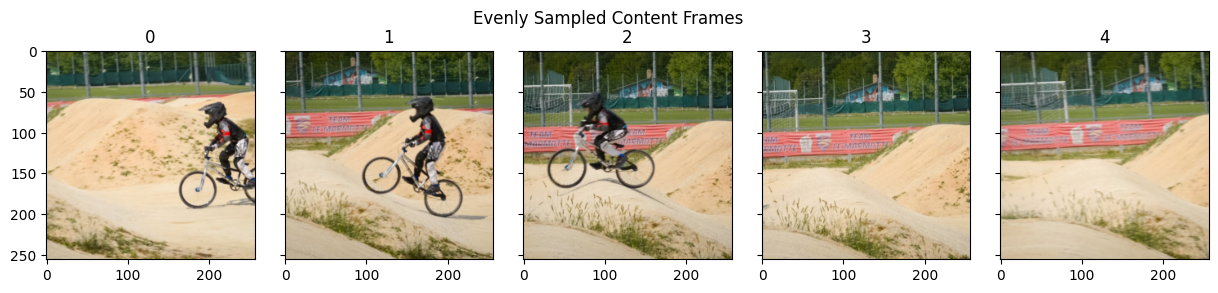

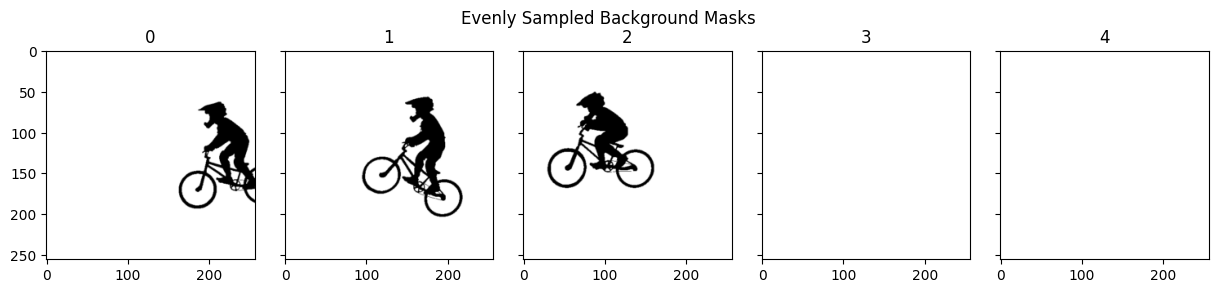

directly decoding 


directly decoding 


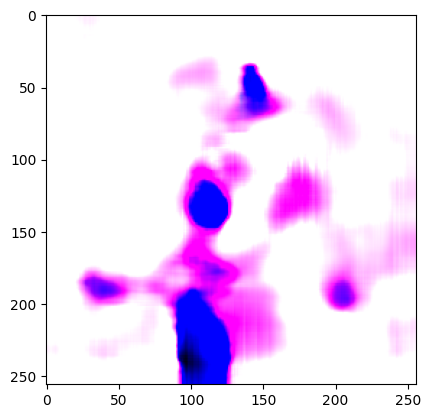

out min max :  tensor(-1.3800, grad_fn=<MinBackward1>) tensor(2.1555, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


directly decoding 


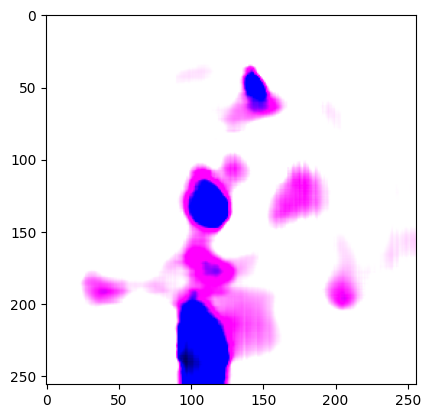

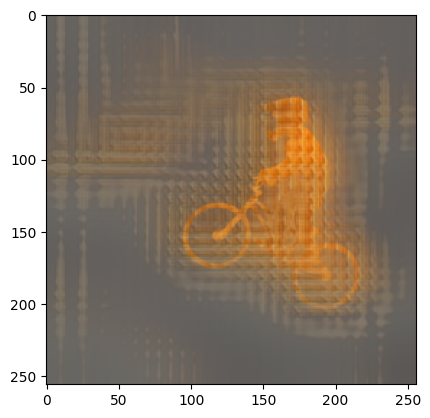

out min max :  tensor(-1.1744, grad_fn=<MinBackward1>) tensor(1.9795, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


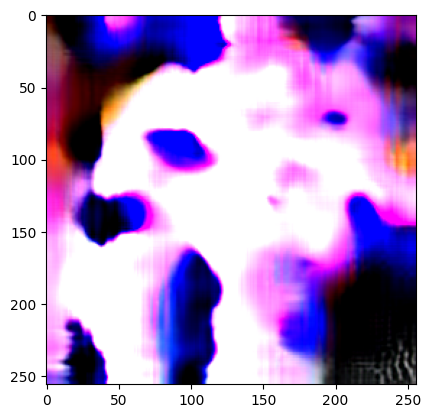

directly decoding 


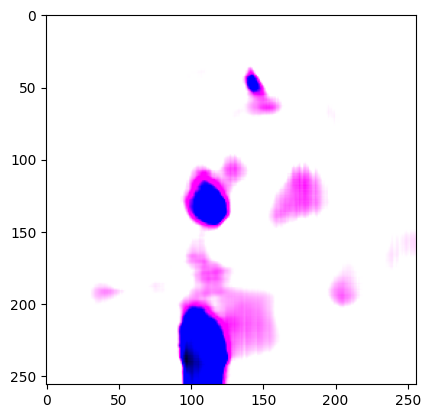

out min max :  tensor(-0.9990, grad_fn=<MinBackward1>) tensor(1.6844, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


directly decoding 


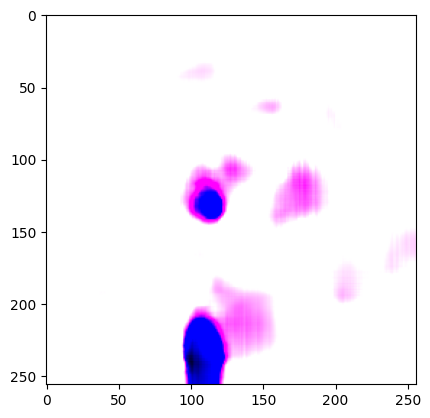

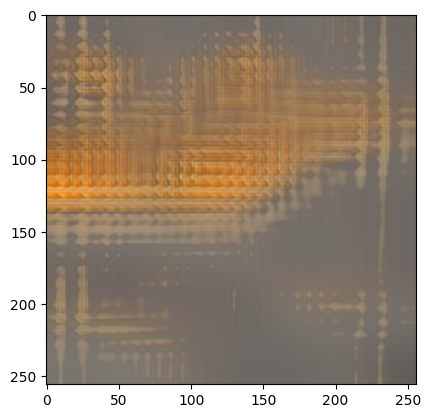

out min max :  tensor(-0.7909, grad_fn=<MinBackward1>) tensor(1.1464, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


directly decoding 


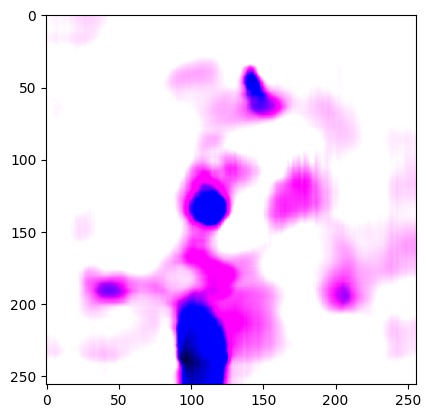

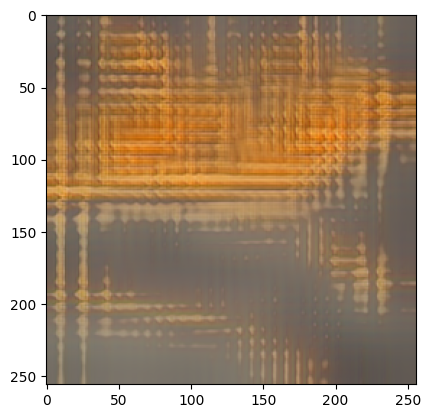

out min max :  tensor(-0.4368, grad_fn=<MinBackward1>) tensor(0.7374, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


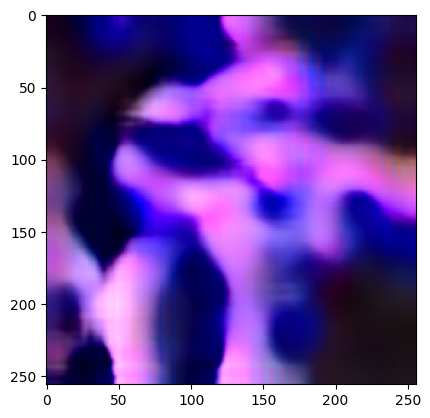

directly decoding 


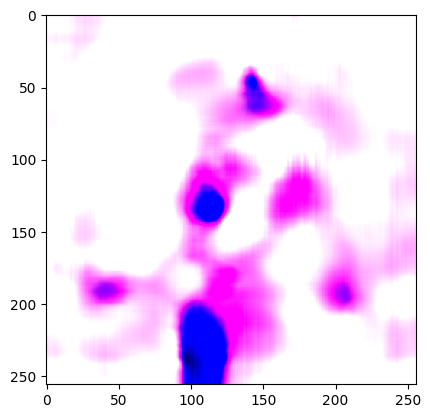

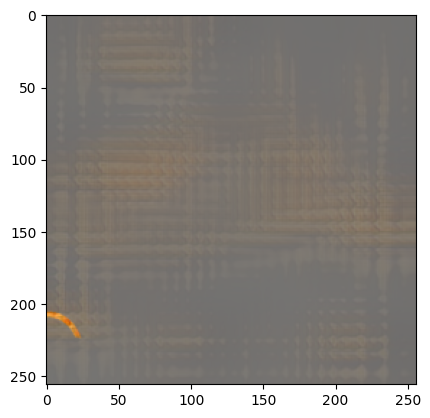

out min max :  tensor(-3.1349, grad_fn=<MinBackward1>) tensor(4.0271, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


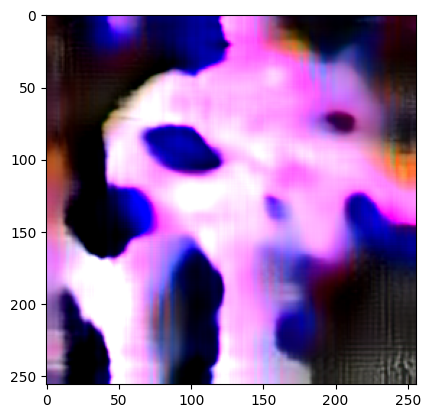

directly decoding 


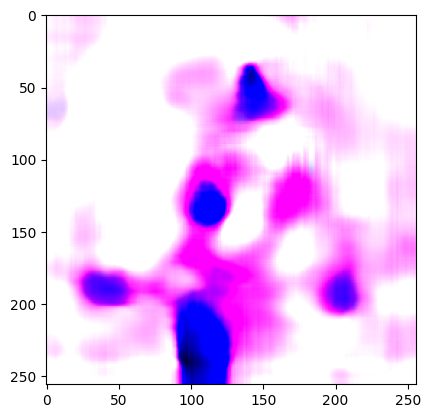

out min max :  tensor(-2.4151, grad_fn=<MinBackward1>) tensor(3.5635, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


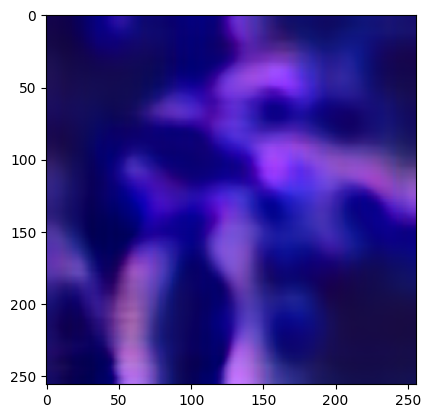

directly decoding 


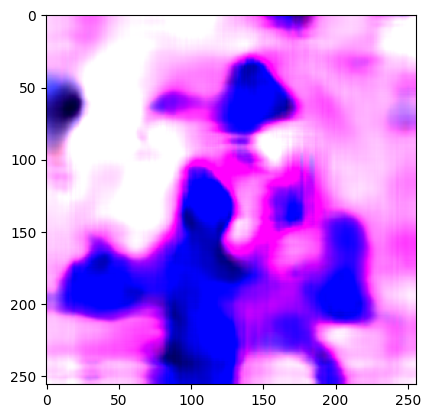

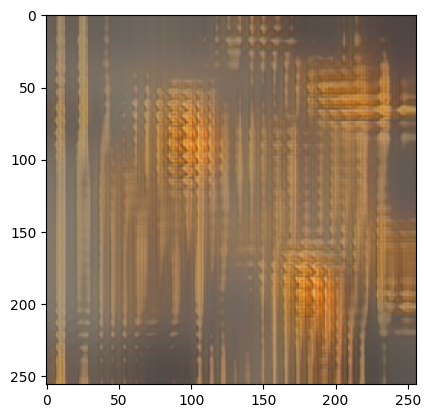

out min max :  tensor(-0.4619, grad_fn=<MinBackward1>) tensor(0.8175, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


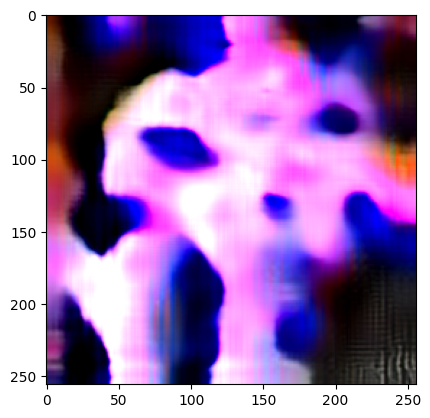

directly decoding 


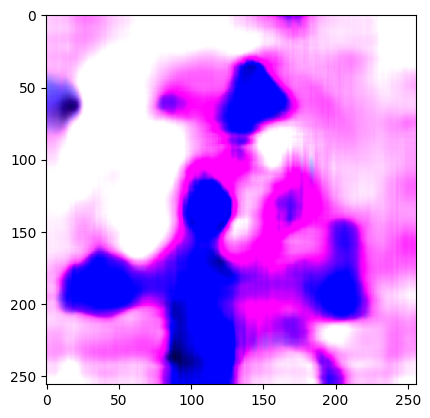

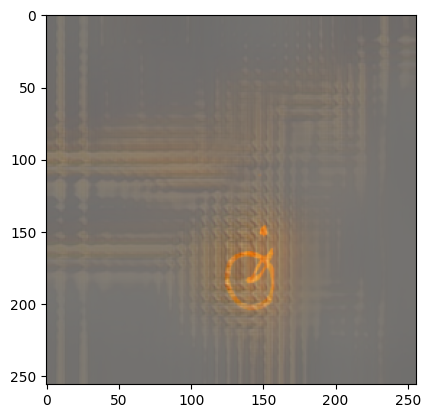

out min max :  tensor(-2.3167, grad_fn=<MinBackward1>) tensor(3.0496, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
directly decoding 


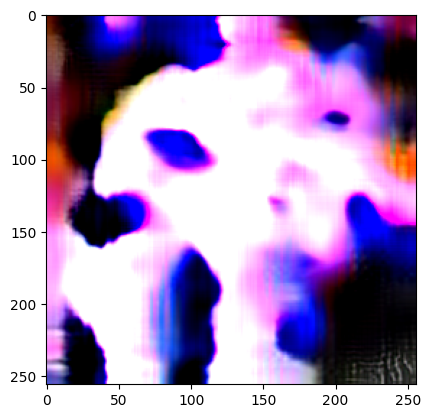

directly decoding 


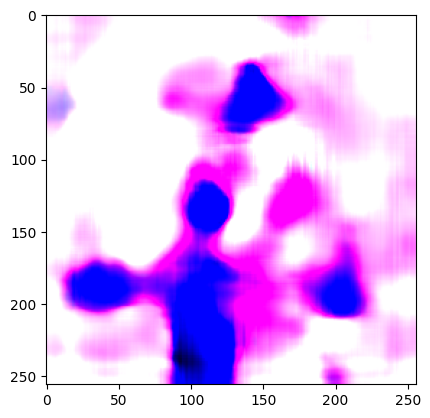

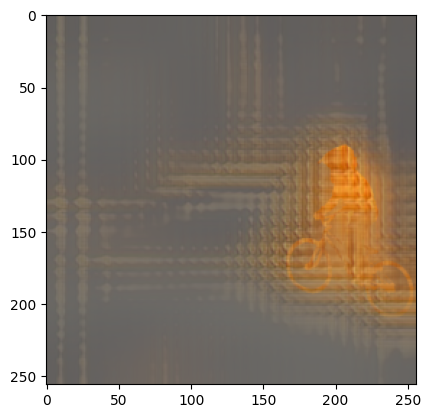

out min max :  tensor(-1.4599, grad_fn=<MinBackward1>) tensor(2.3743, grad_fn=<MaxBackward1>) tensor(0.) tensor(1.)
torch.Size([10, 3, 256, 256])
denormalized out min max :  0 255


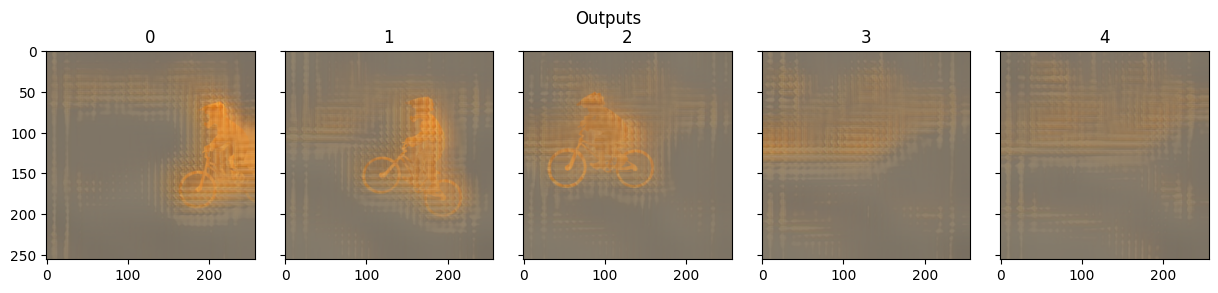

In [33]:
from torchvision.utils import save_image,make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

infer_vgg_feature_extractor = get_VGG_feature_extractor().to(device)

infer_decoder = get_decoder().to(device)
if os.path.exists(checkpoints_root + '/decoder.pth'):
    checkpoint = torch.load(checkpoints_root + '/decoder.pth')
    infer_decoder.load_state_dict(checkpoint)
    print('loaded decoder')

infer_model = MaskedVideoStyleTransfer(infer_decoder).to(device)
if os.path.exists(checkpoints_root + '/ckpt_encdec_7_31.pth'):
    checkpoint = torch.load(checkpoints_root + '/ckpt_encdec_7_31.pth')
    infer_model.load_state_dict(checkpoint)
    print('loaded model')
#freeze param weights of required modules
for child in infer_model.named_children():
    if child[0] in ['vgg_feature_extractor', 'decoder']:
        child[1].requires_grad_(False)

infer_model.eval()

count = 0
random_idx = np.random.randint(5)
for i ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(val_loader):
    if i < random_idx:
        continue
    #cont_img is B x num_frames x 3 x 256 x 256
    bs = cont_imgs.shape[0]
    plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
               title='Evenly Sampled Content Frames')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Foreground Masks')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Background Masks')
    plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
               title='Style Images')

    cpe_1_all = torch.randn(size=(bs, num_classes, 64, 256, 256), dtype=torch.float32).to(device)
    cpe_2_all = torch.randn(size=(bs, num_classes, 128, 128, 128), dtype=torch.float32).to(device)
    cpe_3_all = torch.randn(size=(bs, num_classes, 256, 64, 64), dtype=torch.float32).to(device)
    cpe_4_all = torch.randn(size=(bs, num_classes, 512, 32, 32), dtype=torch.float32).to(device)
    adap_1_all = torch.randn(size=(bs, num_classes, 8, 128, 128), dtype=torch.float32).to(device)
    adap_2_all = torch.randn(size=(bs, num_classes, 16, 64, 64), dtype=torch.float32).to(device)
    adap_3_all = torch.randn(size=(bs, num_classes, 32, 32, 32), dtype=torch.float32).to(device)
    output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
    mask_img_list_prev = torch.randn(size=(bs, num_classes, 3, 256, 256), dtype=torch.float32).to(device)

    output_frames = []
    for frame_idx in range(cont_imgs.shape[1]):
        cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
        mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
        style_img_list = style_img_lists.to(device)
        # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

        all_cont_feats = infer_vgg_feature_extractor(cont_img)
        cont_feat = all_cont_feats['layer4']
        all_style_feats_list = [infer_vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
        style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]

        output, bilateral_grid_list, out_f, out_b, cpe_1_all_, cpe_2_all_, cpe_3_all_, cpe_4_all_, adap_1_all_, adap_2_all_, adap_3_all_ = infer_model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

        output_prev = output.clone().detach()
        mask_img_list_prev = mask_img_list.clone().detach()

        grid_out = make_grid(output, nrow=1, normalize = True)

        plt.imshow(grid_out.cpu().detach().permute(1,2,0).numpy())
        plt.show()
        print('out min max : ', output.min(), output.max(), grid_out.min(), grid_out.max())
        output_frames.append(output)

    output_frames_tensor = torch.cat(output_frames, dim=0).to(device)
    print(output_frames_tensor.shape)
    denormalized_output = denormalize(output_frames_tensor.cpu())
    print('denormalized out min max : ', np.min(denormalized_output), np.max(denormalized_output))
    plot_video(rows=1, cols=5, frame_list=denormalized_output, plot_width=15., plot_height=3.,
               title='Outputs')
    count += 1
    if count > 0:
        break


In [ ]:
print(mask_img_list.shape)
temp = torch.sum(torch.squeeze(mask_img_list)[0][0], dim=0)
print(temp.shape)
print(temp.min(), temp.max())
plt.matshow(temp.detach().cpu().numpy())
plt.show()

temp = torch.sum(torch.squeeze(bilateral_grid_list[0][0]), dim=0)
print(temp.shape)
print(temp.min(), temp.max())
print()
plt.matshow(temp.detach().cpu().numpy())
plt.show()

temp = torch.sum(torch.squeeze(bilateral_grid_list[0][1]), dim=0)
print(temp.shape)
print(temp.min(), temp.max())
plt.matshow(temp.detach().cpu().numpy())
plt.show()

torch.Size([1, 3, 256, 256]) tensor(-0.9765, grad_fn=<MinBackward1>) tensor(1.3759, grad_fn=<MaxBackward1>)


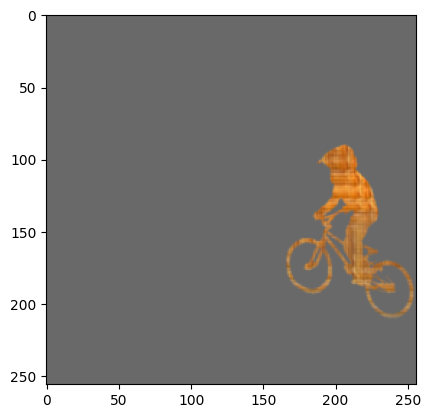

torch.Size([1, 3, 256, 256]) tensor(-1.1959, grad_fn=<MinBackward1>) tensor(2.2584, grad_fn=<MaxBackward1>)


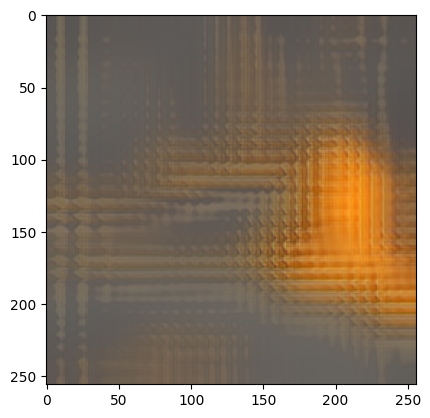

In [29]:
print(out_f.shape, out_f.min(), out_f.max())
plt.imshow(make_grid(out_f[0] * mask_img_list[0,0,:,:,:], normalize=True).cpu().detach().permute(1,2,0))
plt.show()

print(out_b.shape, out_b.min(), out_b.max())
plt.imshow(make_grid(out_b[0], normalize=True).cpu().detach().permute(1,2,0))
plt.show()

In [64]:
!wget https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/download?datasetVersionNumber=1

--2024-05-03 20:52:19--  https://drive.google.com/file/d/1-5pc3fcalfIbVsGpGH22UqCntUjAb49s/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.148.102, 142.250.148.113, 142.250.148.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.148.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing.1’

view?usp=sharing.1      [ <=>                ]  82.82K  --.-KB/s    in 0.03s   

2024-05-03 20:52:19 (2.57 MB/s) - ‘view?usp=sharing.1’ saved [84809]

